In [ ]:
import torch 
import torchvision 
import torch.nn as nn 
import torch.optim as optim 
import torch.nn.functional as F 
from PIL import Image
from torchvision import transforms, datasets
from torch.utils.data import Dataset, DataLoader

In [ ]:
epochs=10

device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.Resize(227),
    transforms.ToTensor()
])
train_data = datasets.CIFAR10(
    root = 'data',
    download = True,
    train = True,
    transform=transform
)
test_data = datasets.CIFAR10(
    root='data',
    download = True,
    train = False,
    transform=transform
)

train_loader = DataLoader(train_data,shuffle=True)
test_loader = DataLoader(test_data,shuffle=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
class VGG16(nn.Module):
  def __init__(self):
    super(VGG16,self).__init__()

    self.conv_layers = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(64,64,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(64,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(128,128,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(128,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256,256,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(256,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),

        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(512,512,kernel_size=3,stride=1,padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),
    )

    self.classifier = nn.Sequential(
        nn.Linear(512*7*7,4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096,4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096,10),
    )

  def forward(self,x):
    output = self.conv_layers(x)
    output = output.view(output.size(0), -1)
    output = self.classifier(output)

    return output

In [ ]:
model = VGG16().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.1)
print(model)

VGG16(
  (conv_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [ ]:
train_accu = []
train_losses = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    running_loss=0
    correct=0
    total=0

    for batch_idx, (data, target) in enumerate(train_loader):
        target = target.type(torch.LongTensor)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() 
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step() 

        running_loss += loss.item()
        _, predicted = output.max(1)
        total += target.size(0)
        correct += predicted.eq(target).sum().item()

    train_loss=running_loss/len(train_loader)
    accu=100.*correct/total
   
    train_accu.append(accu)
    train_losses.append(train_loss)
    
    print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

In [ ]:
eval_losses=[]
eval_accu=[]

def test(model, device, test_loader):
    model.eval() 
    running_loss=0
    correct=0
    total=0
    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            running_loss += loss_fn(output, target).sum().item()
            pred = output.max(1, keepdim=True)[1]
            total += target.size(0)
            correct += pred.eq(target.view_as(pred)).sum().item() 

        test_loss = running_loss/len(test_loader.dataset)  
        accu=100.*correct/total
 
        eval_losses.append(test_loss)
        eval_accu.append(accu)
        print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
        print('-----------------------------------')

In [ ]:
for epoch in range(1, epochs+1):
  print(f"Epoch {epoch}")
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

Epoch 1
Train Loss: 2.325 | Accuracy: 9.978
Test Loss: 2.324 | Accuracy: 10.000
-----------------------------------
Epoch 2
Train Loss: 2.325 | Accuracy: 10.152
Test Loss: 2.334 | Accuracy: 10.000
-----------------------------------
Epoch 3
Train Loss: 2.326 | Accuracy: 9.930
Test Loss: 2.324 | Accuracy: 10.000
-----------------------------------
Epoch 4
Train Loss: 2.326 | Accuracy: 9.984
Test Loss: 2.323 | Accuracy: 10.000
-----------------------------------
Epoch 5
Train Loss: 2.325 | Accuracy: 9.876
Test Loss: 2.335 | Accuracy: 10.000
-----------------------------------
Epoch 6
Train Loss: 2.325 | Accuracy: 10.040
Test Loss: 2.334 | Accuracy: 10.000
-----------------------------------
Epoch 7
Train Loss: 2.325 | Accuracy: 9.982
Test Loss: 2.316 | Accuracy: 10.000
-----------------------------------
Epoch 8
Train Loss: 2.325 | Accuracy: 10.250
Test Loss: 2.315 | Accuracy: 10.000
-----------------------------------
Epoch 9
Train Loss: 2.325 | Accuracy: 10.044
Test Loss: 2.334 | Accur

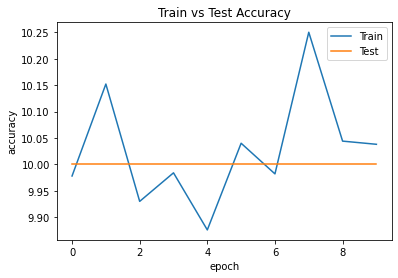

In [ ]:
import matplotlib.pyplot as plt


plt.plot(train_accu)
plt.plot(eval_accu)
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Test'])
plt.title('Train vs Test Accuracy')
 
plt.show()

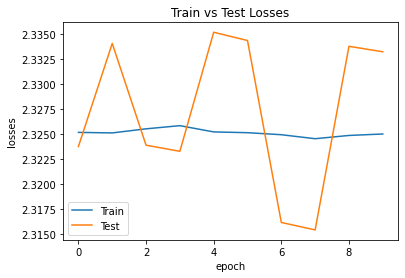

In [ ]:
plt.plot(train_losses)
plt.plot(eval_losses)
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Test'])
plt.title('Train vs Test Losses')
 
plt.show()

In [ ]:
classes = ['airplane', 'automobile', 'bird','cat','deer', 'dog', 'frog','horse','ship','truck']

correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device),target.to(device)
        outputs = model(data)
        _, predictions = torch.max(outputs, 1)

        for label, prediction in zip(target, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 0.0 %
Accuracy for class: automobile is 0.0 %
Accuracy for class: bird  is 0.0 %
Accuracy for class: cat   is 0.0 %
Accuracy for class: deer  is 0.0 %
Accuracy for class: dog   is 0.0 %
Accuracy for class: frog  is 0.0 %
Accuracy for class: horse is 0.0 %
Accuracy for class: ship  is 0.0 %
Accuracy for class: truck is 100.0 %
